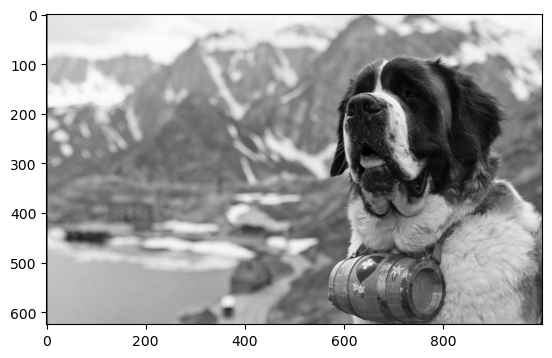

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [2]:
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from glob import glob


image_files = glob('../assets/*.*p*g')
plt.imshow(image.load_img(image_files[0]))
plt.show()


resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
resnet.summary()


1/1 [==============================] - 1s 1s/step
[('n02109525', 'Saint_Bernard', 0.9938198), ('n02111129', 'Leonberg', 0.00451599), ('n02088466', 'bloodhound', 0.00042592667), ('n02102318', 'cocker_spaniel', 0.00023885463), ('n02109047', 'Great_Dane', 0.00022320164)]


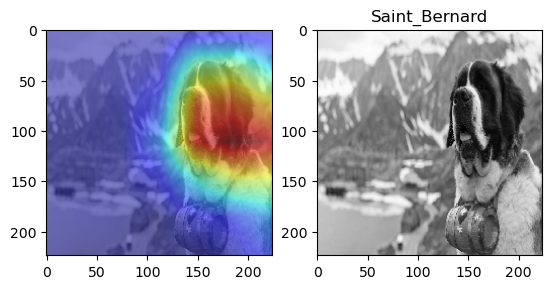

1/1 [==============================] - 0s 92ms/step
[('n02930766', 'cab', 0.7297625), ('n09428293', 'seashore', 0.11231365), ('n04335435', 'streetcar', 0.019641526), ('n03895866', 'passenger_car', 0.011201281), ('n03461385', 'grocery_store', 0.0059195776)]


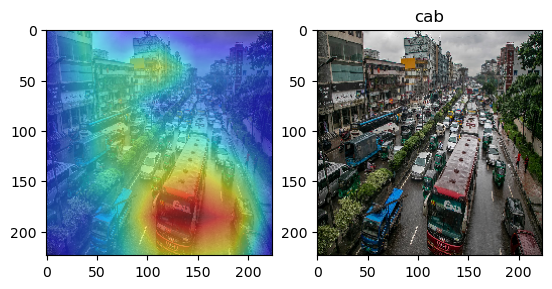

1/1 [==============================] - 0s 94ms/step
[('n04326547', 'stone_wall', 0.27604482), ('n03000134', 'chainlink_fence', 0.2539285), ('n03388043', 'fountain', 0.10107401), ('n03598930', 'jigsaw_puzzle', 0.085269414), ('n03594734', 'jean', 0.058780286)]


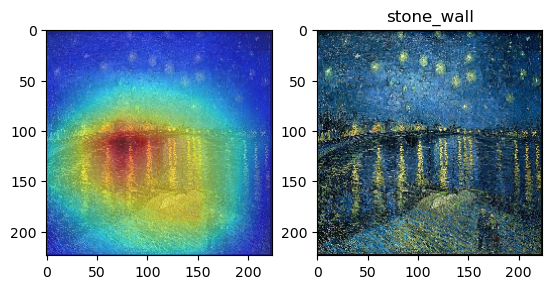

1/1 [==============================] - 0s 99ms/step
[('n02795169', 'barrel', 0.99767977), ('n03160309', 'dam', 0.0008058214), ('n04049303', 'rain_barrel', 0.0007823626), ('n04522168', 'vase', 0.00013399398), ('n03950228', 'pitcher', 9.075439e-05)]


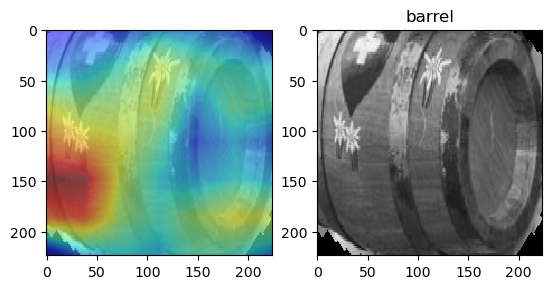

1/1 [==============================] - 0s 93ms/step
[('n02667093', 'abaya', 0.7706422), ('n03450230', 'gown', 0.12476488), ('n03045698', 'cloak', 0.06582459), ('n03866082', 'overskirt', 0.01057972), ('n04584207', 'wig', 0.005361265)]


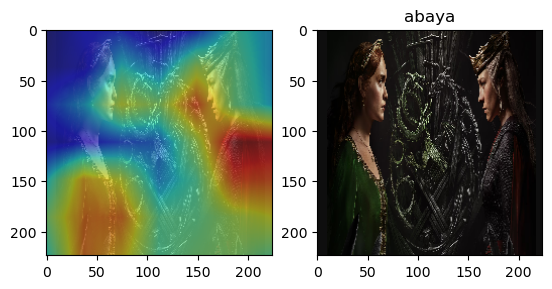

In [4]:
# make a model to get output before flatten
activation_layer = resnet.get_layer('conv5_block3_out')

# create a model object
model = Model(inputs=resnet.input, outputs=activation_layer.output)

# get the feature map weights
final_dense = resnet.get_layer('predictions')
W = final_dense.get_weights()[0]


for image_file in image_files:
  img = image.load_img(image_file, target_size=(224, 224))
  x = preprocess_input(np.expand_dims(img, 0))
  fmaps = model.predict(x)[0] # 7 x 7 x 2048

  probs = resnet.predict(x)
  classnames = decode_predictions(probs)[0]
  print(classnames)
  classname = classnames[0][1]
  pred = np.argmax(probs[0])

  # get the 2048 weights for the relevant class
  w = W[:, pred]

  # "dot" w with fmaps
  cam = fmaps.dot(w)

  # upsample to 224 x 224
  # 7 x 32 = 224
  cam = sp.ndimage.zoom(cam, (32, 32), order=1)

  plt.subplot(1,2,1)
  plt.imshow(img, alpha=0.8)
  plt.imshow(cam, cmap='jet', alpha=0.5)
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.title(classname)
  plt.show()
